# Health, poverty, and education in Nepal districts

## Imports

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import folium
from folium.features import DivIcon
from folium.plugins import MiniMap
import seaborn as sns
from scipy.stats import zscore
import plotly.express as px
import branca
from branca.colormap import linear
import json
from libpysal.weights import Queen
from esda import Moran, Moran_Local
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import pandas as pd
from splot.esda import (
    plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation,
)

# Custom util functions
import sys; sys.path.append("./libraries/")
from libraries.utils import *

# warnings
import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis (EDA)

In [2]:
gdf = gpd.read_file("../data/nepal.shp")

In [3]:
print(gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 62 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          75 non-null     int64   
 1   name_1      71 non-null     object  
 2   name_2      75 non-null     object  
 3   district    75 non-null     object  
 4   depecprov   75 non-null     float64 
 5   povindex    75 non-null     float64 
 6   pcinc       75 non-null     int64   
 7   pcincppp    75 non-null     int64   
 8   pcincmp     75 non-null     int64   
 9   malkids     75 non-null     float64 
 10  lif40       75 non-null     float64 
 11  nosafh20    75 non-null     float64 
 12  population  75 non-null     int64   
 13  boyg1_5     75 non-null     int64   
 14  girlg1_5    75 non-null     int64   
 15  kids1_5     75 non-null     int64   
 16  schoolcnt   75 non-null     int64   
 17  schlpkid    75 non-null     float64 
 18  schlppop    75 non-null     float64 
 19  ad

In [4]:
print(gdf.isnull().sum())

id           0
name_1       4
name_2       0
district     0
depecprov    0
            ..
TOURDAMT     0
TRANDAMT     0
WATDAMT      0
TOTDAMT      0
geometry     0
Length: 62, dtype: int64


Four districts lack **name_1** data, which simply indicates their cardinal direction (west, east, etc.). We’re not dropping them because this field isn’t used in our analysis.

In [5]:
print(gdf.head())

   id   name_1       name_2   district  depecprov  povindex  pcinc  pcincppp  \
0   1     None  Dhaualagiri    Baglung      27.01     27.33    354       573   
1   2     None  Dhaualagiri    Mustang      31.51     31.16   1189      1922   
2   3     None  Dhaualagiri     Myagdi      30.03     28.54    636      1028   
3   4     None  Dhaualagiri     Parbat      21.84     24.62    627      1013   
4   5  Central      Bagmati  Bhaktapur      22.58     19.43    854      1379   

   pcincmp  malkids  ...  HEALTDAMT  HUMDAMT  INDDAMT  MULTDAMT  SOCDAMT  \
0    25613     42.9  ...    3584409   172736   369324   8050858  1308661   
1    85957     54.7  ...    2253911   172736        0   3712798   633763   
2    45986     47.5  ...    2279653   172736   369324  11784759   964089   
3    45289     26.2  ...      26574        0   369324   4741985        0   
4    61686     26.9  ...    1338957   172736        0   2421424  1652237   

   TOURDAMT  TRANDAMT   WATDAMT   TOTDAMT  \
0         0     1

In [6]:
print(gdf.columns)

Index(['id', 'name_1', 'name_2', 'district', 'depecprov', 'povindex', 'pcinc',
       'pcincppp', 'pcincmp', 'malkids', 'lif40', 'nosafh20', 'population',
       'boyg1_5', 'girlg1_5', 'kids1_5', 'schoolcnt', 'schlpkid', 'schlppop',
       'ad_illit', 'ad_ilgt50', 'lon', 'lat', 'AGCAMT', 'BANKCAMT', 'BUDGCAMT',
       'COMMCAMT', 'CONCAMT', 'EDUCAMT', 'ENGYCAMT', 'ENVCAMT', 'FORCAMT',
       'GOVCAMT', 'HEALTCAMT', 'HUMCAMT', 'INDCAMT', 'MULTCAMT', 'SOCCAMT',
       'TOURCAMT', 'TRANCAMT', 'WATCAMT', 'TOTCAMT', 'AGDAMT', 'BANKDAMT',
       'BUDGDAMT', 'COMMDAMT', 'CONDAMT', 'EDUDAMT', 'ENGYDAMT', 'ENVDAMT',
       'FORDAMT', 'GOVDAMT', 'HEALTDAMT', 'HUMDAMT', 'INDDAMT', 'MULTDAMT',
       'SOCDAMT', 'TOURDAMT', 'TRANDAMT', 'WATDAMT', 'TOTDAMT', 'geometry'],
      dtype='object')


In [7]:
print(gdf.geometry)

0     POLYGON ((83.10834 28.6202, 83.1056 28.60976, ...
1     POLYGON ((83.99726 29.31675, 84 29.31576, 84 2...
2     POLYGON ((83.50688 28.79306, 83.51024 28.78809...
3     POLYGON ((83.70261 28.39837, 83.70435 28.39452...
4     POLYGON ((85.52173 27.71822, 85.52359 27.71375...
                            ...                        
70    POLYGON ((83.02333 28.10508, 83.02967 28.09924...
71    POLYGON ((83.19185 28.26453, 83.20638 28.25558...
72    POLYGON ((84.10302 27.86387, 84.09755 27.85927...
73    POLYGON ((83.37988 27.95869, 83.37875 27.95583...
74    POLYGON ((83.30704 27.76594, 83.31587 27.76234...
Name: geometry, Length: 75, dtype: geometry


In [8]:
print(gdf.geom_type.value_counts()) 

Polygon    75
Name: count, dtype: int64


In [9]:
print(gdf.is_valid.value_counts())

True    75
Name: count, dtype: int64


In [10]:
print(gdf.crs)

EPSG:4326


In [11]:
gdf_proj = gdf.to_crs(epsg=32645)

In [12]:
gdf_merc = gdf.to_crs(epsg=3857)

In [13]:
geojson = json.loads(gdf_proj.to_json())

<Axes: >

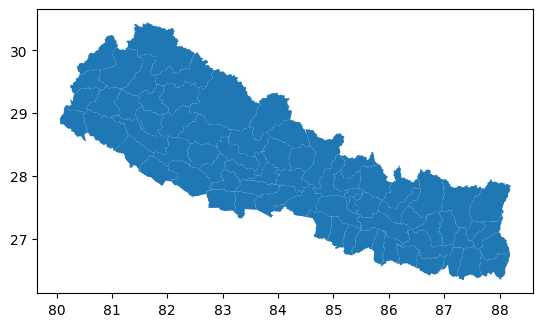

In [14]:
#checking if we have the correct map
gdf.plot()

## Choropleth maps

### Univariate Choropleth Maps

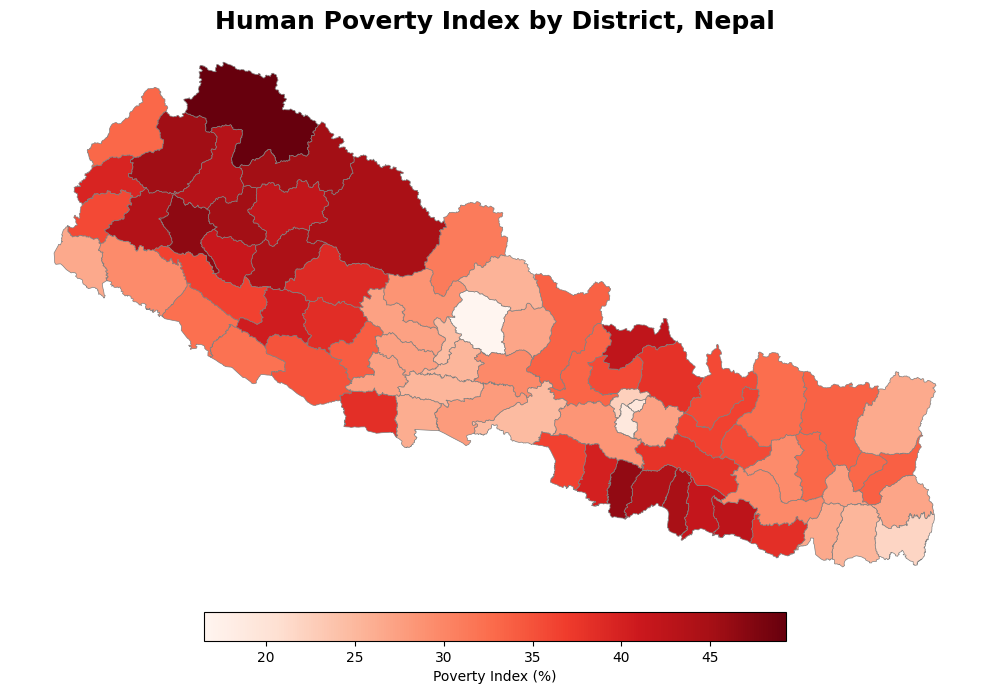

In [15]:
choropleth_mapping(gdf, variables="povindex", title="Human Poverty Index by District, Nepal", legend_label="Poverty Index (%)")

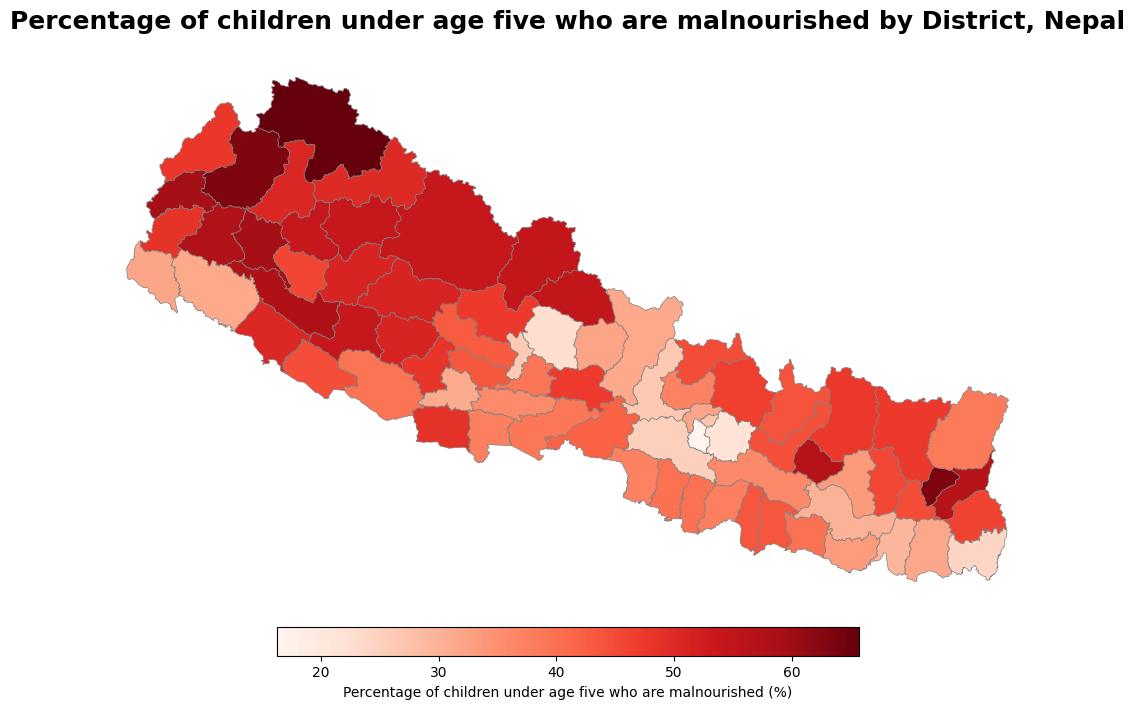

In [16]:
choropleth_mapping(gdf, variables="malkids", title="Percentage of children under age five who are malnourished by District, Nepal", legend_label="Percentage of children under age five who are malnourished (%)")

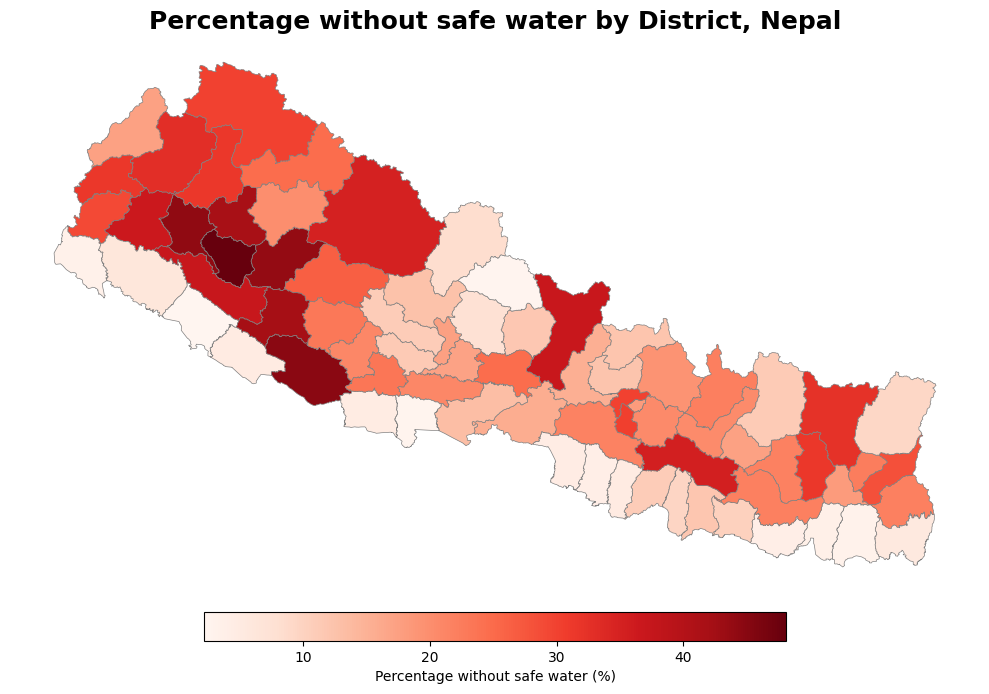

In [17]:
choropleth_mapping(gdf, variables="nosafh20", title="Percentage without safe water by District, Nepal", legend_label="Percentage without safe water (%)")

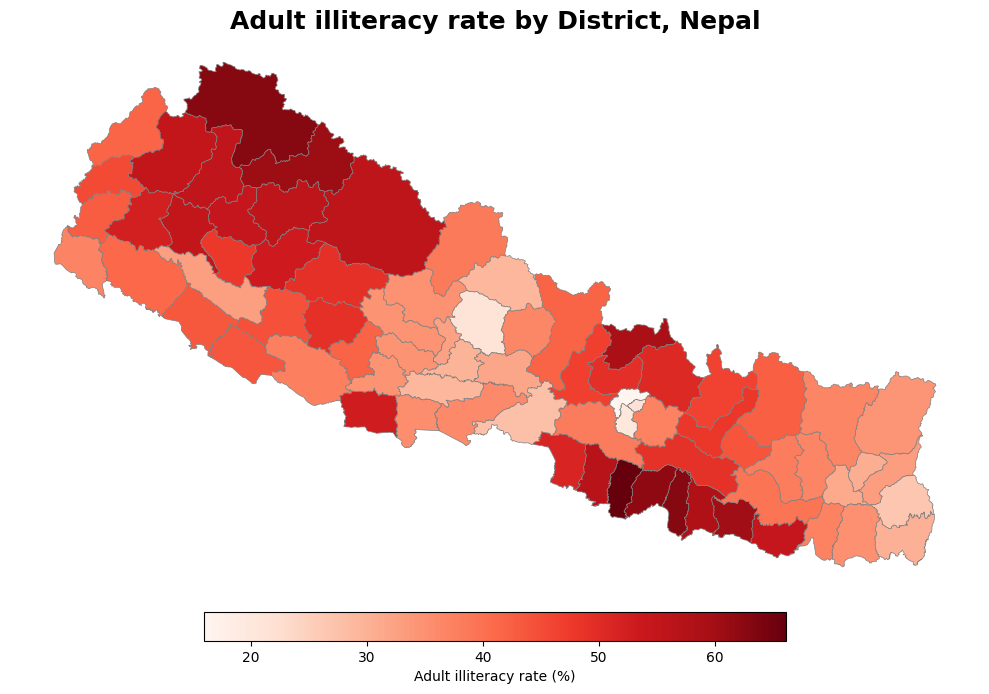

In [18]:
choropleth_mapping(gdf, variables="ad_illit", title="Adult illiteracy rate by District, Nepal", legend_label="Adult illiteracy rate (%)")

### Bivariate Choropleth Maps

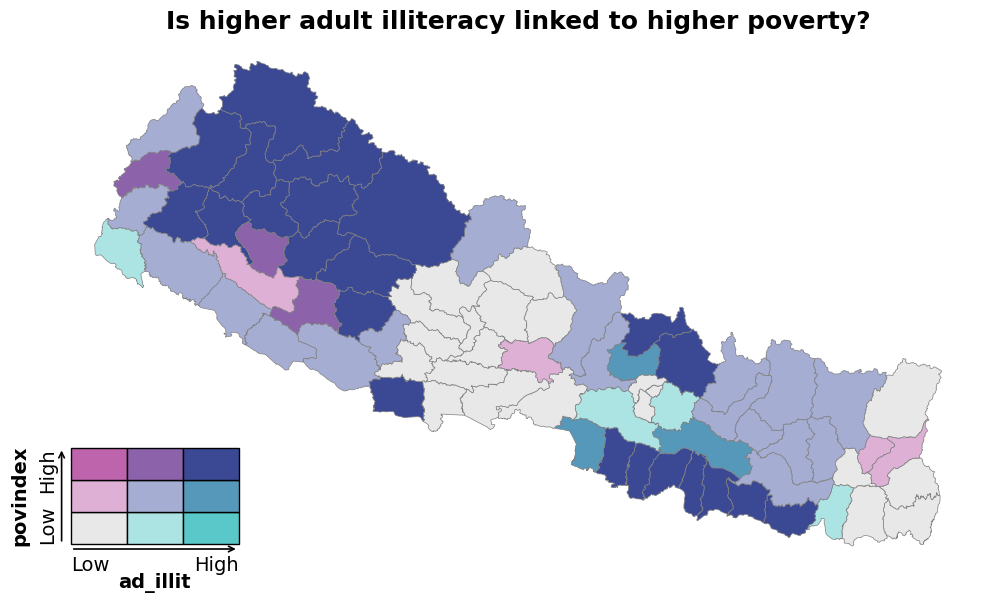

In [19]:
# bivariate choropleth map - Adult illiteracy vs Poverty
choropleth_mapping(gdf, variables=("ad_illit", "povindex"), title="Is higher adult illiteracy linked to higher poverty?")

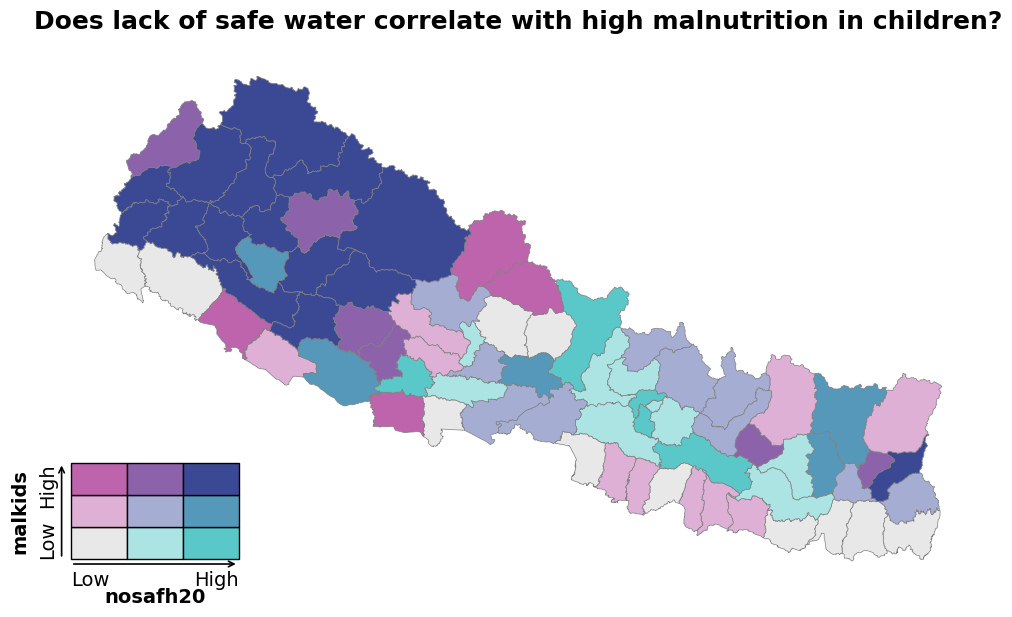

In [20]:
# bivariate choropleth map - Lack of Safe Water vs Child Malnutrition
choropleth_mapping(gdf, variables=("nosafh20", "malkids"), title="Does lack of safe water correlate with high malnutrition in children?")

### Pearson’s r and	p-value

In [21]:
r_ep, p_ep = pearson_report(gdf, "ad_illit", "povindex")
print(f"Adult Illiteracy vs Poverty: r = {r_ep:.2f}, p = {p_ep:.4f}")

r_wm, p_wm = pearson_report(gdf, "nosafh20", "malkids")
print(f"Lack of Safe Water vs Child Malnutrition: r = {r_wm:.2f}, p = {p_wm:.4f}")

Adult Illiteracy vs Poverty: r = 0.92, p = 0.0000
Lack of Safe Water vs Child Malnutrition: r = 0.36, p = 0.0017


### Lowest and Higest values per district for some Variables

In [22]:
bottom5, top5 = extreme_value_variables(gdf, "povindex", n=5)

Lowest 5 districts by povindex:
Kaski: 16.50
Lalitpur: 19.18
Bhaktapur: 19.43
Jhapa: 21.82
Kathmandu: 22.45

Highest 5 districts by povindex:
Humla: 49.26
Achham: 46.68
Rautahat: 46.43
Bajhang: 45.32
Mugu: 45.22


In [23]:
bottom5, top5 = extreme_value_variables(gdf, "malkids", n=5)

Lowest 5 districts by malkids:
Lalitpur: 16.20
Kavrepalanchok: 21.70
Kaski: 22.90
Jhapa: 24.20
Makwanpur: 25.10

Highest 5 districts by malkids:
Humla: 65.70
Terhathum: 63.40
Bajhang: 63.20
Baitadi: 59.20
Achham: 59.20


In [24]:
bottom5, top5 = extreme_value_variables(gdf, "nosafh20", n=5)

Lowest 5 districts by nosafh20:
Bardiya: 2.14
Manang: 2.42
Rupandehi: 2.50
Morang: 3.08
Kanchanpur: 3.32

Highest 5 districts by nosafh20:
Dailekh: 48.12
Dang: 44.72
Achham: 44.31
Jajarkot: 43.91
Salyan: 42.19


In [25]:
bottom5, top5 = extreme_value_variables(gdf, "ad_illit", n=5)

Lowest 5 districts by ad_illit:
Kathmandu: 15.96
Lalitpur: 20.32
Kaski: 21.43
Bhaktapur: 21.87
Ilam: 26.54

Highest 5 districts by ad_illit:
Rautahat: 66.11
Mahottari: 62.96
Humla: 62.78
Sarlahi: 62.00
Mugu: 60.75


## Do the poorest districts tend to sit next to each other on the map ? - Global Moran's I and LISA

In [26]:
#queen contiguity weights matrix
w = Queen.from_dataframe(gdf_proj, use_index=True)
# standardize spatial weights matrix
w.transform = "R" # using row standardization

y = gdf_proj["povindex"].values
mi = Moran(y, w)
print(f"Global Moran's I for povindex: I = {mi.I:.2f}, p-value = {mi.p_sim:.4f}")

Global Moran's I for povindex: I = 0.64, p-value = 0.0010


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.64', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.64)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

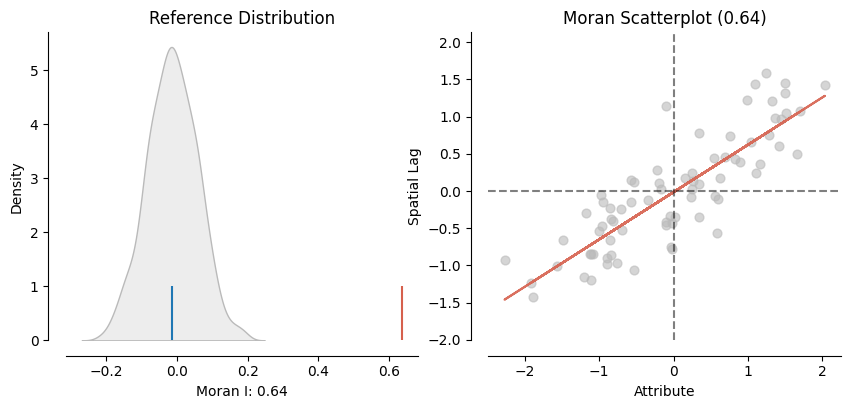

In [27]:
plot_moran(mi)

The Moran scatterplot for district level poverty reveals a strong positive link between each district’s standardized poverty score and the average poverty of its neighbors. While the points aren’t perfectly on the line, the steep slope (Moran’s I = 0.64) and a very low Moran's p-value (p = 0.001) show that similar poverty levels cluster far more than chance would allow.

Most districts land in the High–High quadrant (high poverty areas surrounded by high poverty neighbors) or the Low–Low quadrant (low poverty areas surrounded by low poverty neighbors), highlighting clear hotspots and coldspots. Just a few districts fall into the off diagonal quadrants as spatial outliers, meaning their poverty level diverge somehow from that of their surrounding districts.

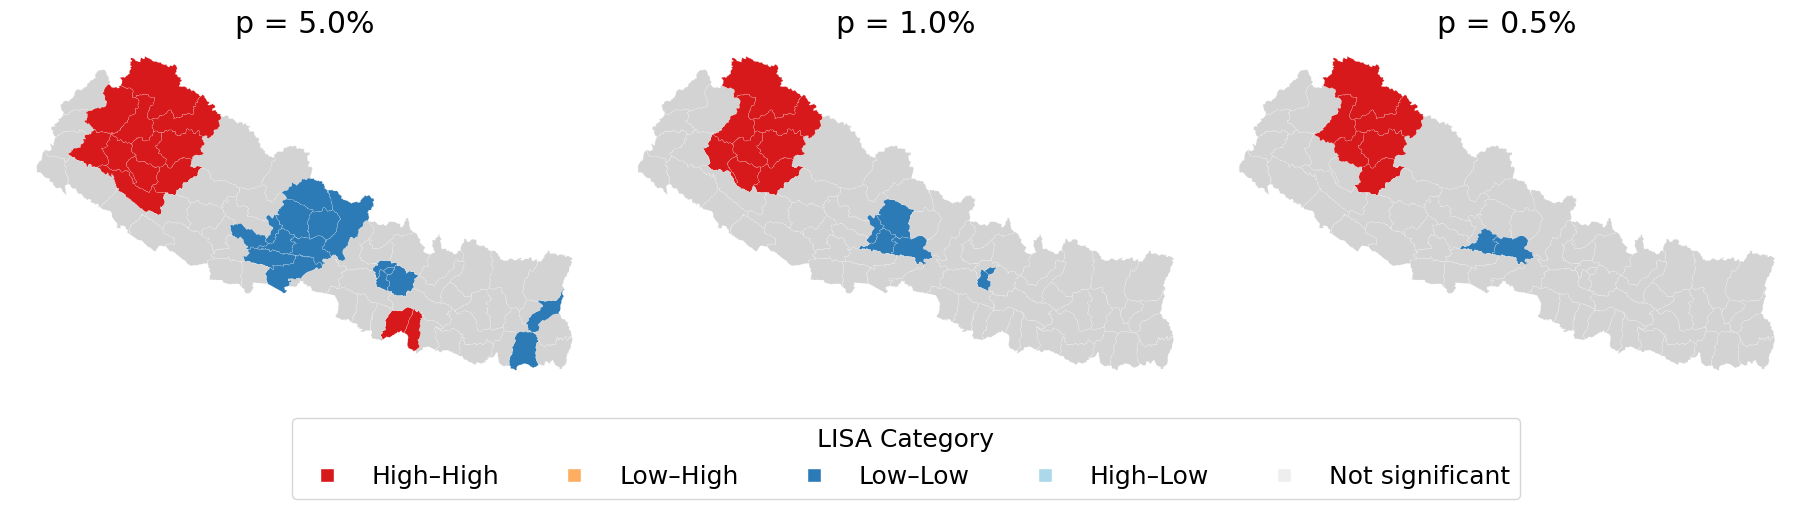

In [28]:
lisa = Moran_Local(y, w)

fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

plt.rcParams.update({'font.size': 18})

# lisa_cluster(lisa, gdf_proj, 0.05, ax=axs[0])
# axs[0].set_title('p = 5%')

# lisa_cluster(lisa, gdf_proj, 0.01, ax=axs[1])
# axs[1].set_title('p = 1%')

# lisa_cluster(lisa, gdf_proj, 0.005, ax=axs[2])
# axs[2].set_title('p = 0.5%')

# for p = 5%, 1%, 0.5%
for ax, p in zip(axs, [0.05, 0.01, 0.005]):
    lisa_cluster(lisa, gdf_proj, p=p, ax=ax)
    ax.set_title(f"p = {float(p*100)}%")
    leg = ax.get_legend()
    if leg:
        leg.remove()

# removed the build in legend which repeats three times and just making a single shared legend
legend_elements = [
    Line2D([0], [0], marker="s", color="w", label="High–High", # high‐high (hot spot)
           markerfacecolor='#d7191c', markersize=10),
    Line2D([0], [0], marker="s", color="w", label="Low–High",   # low‐high  (spatial outlier - donut)
           markerfacecolor='#fdae61', markersize=10),
    Line2D([0], [0], marker="s", color="w", label="Low–Low", # low‐low   (cold spot)
           markerfacecolor='#2c7bb6', markersize=10),
    Line2D([0], [0], marker="s", color="w", label="High–Low", # high‐low  (spatial outlier)
           markerfacecolor='#abd9e9', markersize=10),
    Line2D([0], [0], marker="s", color="w", label="Not significant",
           markerfacecolor="#EEEEEE", markersize=10),
]

fig.legend(
    handles=legend_elements,
    loc="lower center",
    ncol=5,
    title="LISA Category",
    fontsize=18,
    title_fontsize=18
)


plt.show()

The smaller the p-value, the lower is our threshold for statistical significance. So, the lower the p-value, the lower is the likelihood of getting the same spatial pattern randomly. Comparing the cluster plots for the p-values, we can see that the LISA analysis with a p-value of 1% classifies more areas as statistically not significant, and finds fewer hotspots/coldspots, than the LISA analysis with a p-value of 5%. On the other hand we can see even way fewer hotspots/coldspots for p = 0.5%.

## Which districts share similar socioeconomic profiles? - Spatial Clustering (k-means)

In [29]:
#standardizing all chosen variables before clustering
vars_to_cluster = ["povindex", "malkids", "nosafh20", "ad_illit", "pcinc", "depecprov"]
X = gdf[vars_to_cluster].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Silhouette Score and Calinski-Harabasz Index for finding the best k

In [30]:
# calculating the silhouette score and calinski-harabasz index for different k values in order to find the best number of k clusters
ks = range(2, 8)
sil_scores = []
ch_scores  = []

for k in ks:
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels).round(3))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels).round(3))

df_metrics = pd.DataFrame({
    "k": ks,
    "silhouette": sil_scores,
    "calinski-harabasz": ch_scores
})

print(df_metrics.to_string(index=False))

 k  silhouette  calinski-harabasz
 2       0.339             48.718
 3       0.295             42.667
 4       0.292             36.813
 5       0.311             38.936
 6       0.302             35.586
 7       0.269             34.948


The higher the Silhouette Score and Calinski-Harabasz Index the better the k.

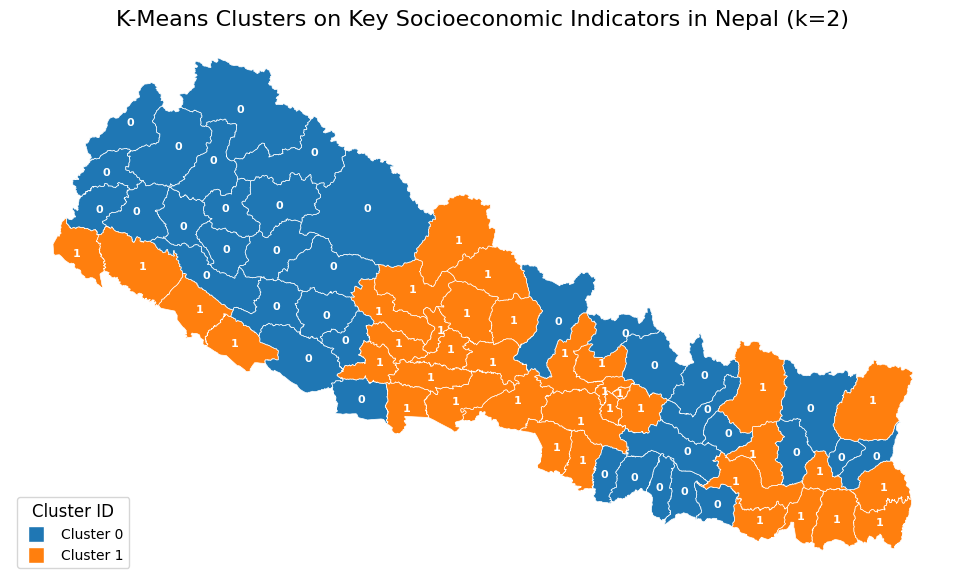

In [31]:
# 2 clusters due to the high silhouette score and calinski-harabasz index for k=2
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
gdf["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

gdf_merc = gdf.to_crs(epsg=3857)
palette = ListedColormap(plt.cm.get_cmap("tab10").colors[:n_clusters])

fig, ax = plt.subplots(figsize=(10, 12))
ax.set_facecolor("#f0f0f0")  

gdf_merc.plot(
    column="kmeans_cluster",
    categorical=True,
    cmap=palette,
    linewidth=0.5,
    edgecolor="white",
    ax=ax,
    legend=False
)

# adding the cluster centroids
gdf_merc["centroid"] = gdf_merc.geometry.representative_point()

for idx, row in gdf_merc.iterrows():
    ax.text(
        row["centroid"].x,
        row["centroid"].y,
        str(int(row["kmeans_cluster"])),
        ha="center",
        va="center",
        fontsize=8,
        fontweight="bold",
        color="white"
    )

handles = [plt.Line2D([0], [0], marker="s", color="w", label=f"Cluster {i}", markerfacecolor=palette(i), markersize=12)
    for i in range(n_clusters)
]

#adding the legend in the lower left corner
ax.legend(handles=handles, title="Cluster ID", loc="lower left", frameon=True, facecolor="white", fontsize=10, title_fontsize=12)


ax.set_title("K-Means Clusters on Key Socioeconomic Indicators in Nepal (k=2)", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [32]:
#mean values of the variables in each cluster
k_n_means = gdf.groupby("kmeans_cluster")[vars_to_cluster].mean().round(2)
print("Mean indicator values:")
k_n_means

Mean indicator values:


,povindex,malkids,nosafh20,ad_illit,pcinc,depecprov
kmeans_cluster,,,,,,
0,39.81,49.58,26.83,49.49,539.05,38.20
1,27.95,36.21,13.02,35.74,793.95,24.62


In [33]:
#mean values of the variables in each cluster
k_n_means_melt = k_n_means.copy()
k_n_means_melt["id"] = k_n_means.index

k_n_means_melt = pd.melt(k_n_means_melt, id_vars = "id", value_vars = k_n_means_melt.columns[:-1]) 
print("Mean indicator values:")
k_n_means_melt

Mean indicator values:


,id,variable,value
0,0,povindex,39.81
1,1,povindex,27.95
2,0,malkids,49.58
3,1,malkids,36.21
4,0,nosafh20,26.83
5,1,nosafh20,13.02
6,0,ad_illit,49.49
7,1,ad_illit,35.74
8,0,pcinc,539.05
9,1,pcinc,793.95


All variables are expressed as percentages (%), except **pcinc** (Per Capita Income), which is measured in Nepalese rupees (NPR).

## How does school availability vary across districts? - Interactive Map (number of schools per 1,000 population)

In [34]:
interactive_map(gdf)

In order to view the interactive map the notebook need to be ran in the local machine. It cannot be viewed via GitHub.